In [1]:
import os
import sys
import cv2
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform, color
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

use_gpu = torch.cuda.is_available()

In [2]:
def segment(img, checked, segmentation, counter, x, y):
    if x < 0 or x >= img.shape[0] or y < 0 or y >= img.shape[1]:
        return 0
    if img[x, y] < 255 or checked[x, y]:
        return 0
    checked[x, y] = 1
    segmentation[x, y] = counter
    return 1 + segment(img, checked, segmentation, counter, x + 1, y) + \
            segment(img, checked, segmentation, counter, x - 1, y) + \
            segment(img, checked, segmentation, counter, x, y + 1) + \
            segment(img, checked, segmentation, counter, x, y - 1)    

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, indices, prepare=True, transform=None):
        self.root_dir = root_dir
        self.indices = indices  # Which image numbers to take
        self.transform = transform
        self.data = {}
        if prepare:
            self._generate(indices)
    
    def _generate(self, indices):
        for i in indices:
            seg, icon = self.__getitem__(i - 1)
            self.data[i] = (seg, icon)
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        if index + 1 in self.data:
            return self.data[index + 1]
        try:
            edge_name = os.path.join(self.root_dir, 'edges/', str(index + 1) + '.png')
            icon_name = os.path.join(self.root_dir, 'icons/', str(index + 1) + '.png')
            edge = io.imread(edge_name, as_gray=True) * 255
            
            edge_blur = cv2.GaussianBlur(edge, (3, 3), 1)

            checked = np.zeros(edge.shape)
            segmentation = np.zeros(edge.shape)
            counter = 1
            
            for x in range(edge.shape[0]):
                for y in range(edge.shape[1]):
                    s = segment(edge_blur, checked, segmentation, counter, x, y)
                    if s > 0:
                        counter += 1
            segmentation = segmentation * (255 / counter)
            
            segmentation = segmentation.reshape((120, 120, 1))

            segmentation = segmentation.transpose((2, 0, 1))
            icon = io.imread(icon_name)
            icon = color.rgba2rgb(icon)
            icon = icon.transpose((2, 0, 1))
            
            return segmentation, icon
        except ValueError:
            print(index)
            raise ValueError

In [4]:
np.random.seed(1000)
indices = np.arange(1, 10001)
np.random.shuffle(indices)
np.random.seed(None)
sys.setrecursionlimit(120 * 120)



In [5]:
train_data = ImageDataset('./data/', indices[:7000])
validation_data = ImageDataset('./data/', indices[7000:8500])


In [5]:
class Res(nn.Module):
    def __init__(self):
        super(Res, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.conv2(y)
        return y + x

    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9, padding=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            Res(),
            Res(),
            Res(),
            Res(),
            Res(),
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=9, padding=4),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.residual(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.final(x)
        return x

In [6]:
BATCH_SIZE = 4
LR = 0.001
EPOCHS = 30

In [8]:
# Second component of loss is a VGG-16 DNN
vgg = models.vgg16(pretrained=True).cuda()
clipped = list(vgg.children())[0][:9]
clipped_model = torch.nn.Sequential(*clipped).cuda()

In [7]:
# Borrowed from https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
# Credit to user Himanshu Tyagi
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [10]:
def validate(model, val_loader):
    model.eval()
    val_loss = 0
    for edges, icons in tqdm(val_loader):
        if use_gpu:
            edges = edges.cuda()
        icons = icons.float()
        res = model(edges.float())
        res = res.detach().cpu().numpy()
        icons = icons.numpy()
        val_loss += psnr(res, icons)      
    print(f"Validation PSNR: {val_loss / len(val_loader)}")

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer):
    for e in range(EPOCHS):
        running_loss = 0
        model.train()
        for edges, icons in tqdm(train_loader):
            if use_gpu:
                edges = edges.cuda()
                icons = icons.cuda()

            res = model(edges.float())
            icons = icons.float()

            loss = criterion(res, icons)
            with torch.no_grad():
                vgg_clip = clipped_model(icons)
            loss += criterion(clipped_model(res), vgg_clip)

            var_loss = 0.00001 * (torch.sum(torch.sqrt(
                torch.pow(icons[:, :, :, :-1] - icons[:, :, :, 1:], 2).flatten() + \
                torch.pow(icons[:,:,:-1,:] - icons[:,:,1:,:], 2).flatten()
            )))
            
            loss += var_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print(f"Epoch {e+1}")
            print(f"Training loss: {running_loss / len(train_loader)}")
            validate(model, val_loader)

In [13]:
net = Net()
if use_gpu:
    net = net.cuda()

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8)

train(net, train_loader, validation_loader, criterion, optimizer)


Epoch 1
Training loss: 1.5338801664284298



Validation PSNR: 7.711653503331905



Epoch 2
Training loss: 1.028340202995709



Validation PSNR: 12.1050304191758



Epoch 3
Training loss: 0.9184178201641355



Validation PSNR: 12.68603878082796



Epoch 4
Training loss: 0.8619921126535961



Validation PSNR: 13.157316952494087



Epoch 5
Training loss: 0.8220953223024096



Validation PSNR: 13.46971666035693



Epoch 6
Training loss: 0.7874024152415139



Validation PSNR: 13.488338647128032



Epoch 7
Training loss: 0.7568230312381472



Validation PSNR: 13.595211430500013



Epoch 8
Training loss: 0.7300550164835794



Validation PSNR: 14.022867648205123



Epoch 9
Training loss: 0.7030358693259103



Validation PSNR: 14.012316083997069



Epoch 10
Training loss: 0.6810919252123151



Validation PSNR: 14.332522673449033



Epoch 11
Training loss: 0.6608222277845656



Validation PSNR: 14.567297883096838



Epoch 12
Training loss: 0.6417310646772385



Validation PSNR: 14.702204822991778



Epoch 13
Training loss: 0.6222384107964379



Validation PSNR: 14.980068823312987



Epoch 14
Training loss: 0.6061717650720051



Validation PSNR: 15.0434813398789



Epoch 15
Training loss: 0.5920563839673996



Validation PSNR: 15.367055639824553



Epoch 16
Training loss: 0.5772098622492382



Validation PSNR: 15.30109032589162



Epoch 17
Training loss: 0.563537130526134



Validation PSNR: 15.51942838336016



Epoch 18
Training loss: 0.5509784205981664



Validation PSNR: 15.60252471343484



Epoch 19
Training loss: 0.539250164926052



Validation PSNR: 15.961631486996179



Epoch 20
Training loss: 0.5298767634970801



Validation PSNR: 15.987347211653548



Epoch 21
Training loss: 0.5181655784760203



Validation PSNR: 15.94675057224244



Epoch 22
Training loss: 0.5077657562494278



Validation PSNR: 16.130918106009197



Epoch 23
Training loss: 0.49956547251769473



Validation PSNR: 16.45416911263324



Epoch 24
Training loss: 0.49241189978803906



Validation PSNR: 16.195515899057625



Epoch 25
Training loss: 0.48269903007575443



Validation PSNR: 16.51143027048193



Epoch 26
Training loss: 0.47503017362526484



Validation PSNR: 16.765991085278337



Epoch 27
Training loss: 0.46690231440748486



Validation PSNR: 16.660344301087463



Epoch 28
Training loss: 0.46105311988932746



Validation PSNR: 17.056187942348078



Epoch 29
Training loss: 0.45426210365976605



Validation PSNR: 17.025480240969873



Epoch 30
Training loss: 0.4471344561236245



Validation PSNR: 17.33522001449409


In [20]:
torch.save(net.state_dict(), 'CSIsegmentation.pt')

In [8]:
net = Net()
device = torch.device('cuda')
net.load_state_dict(torch.load('CSIsegmentation.pt'))
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (residual): Sequential(
    (0): Res(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Ba

In [10]:
test_data = ImageDataset('./data/', indices[8500:])
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

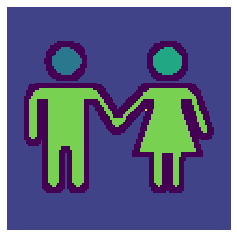

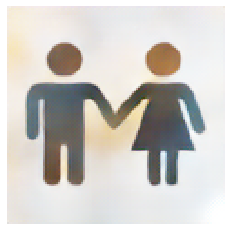

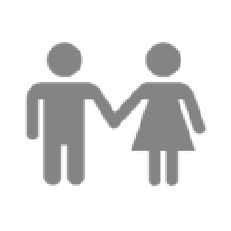

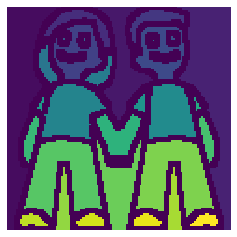

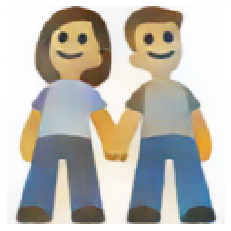

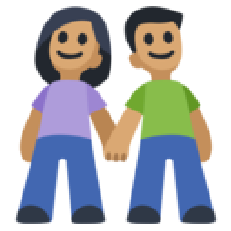

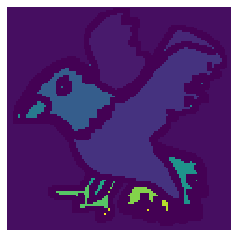

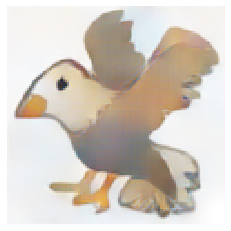

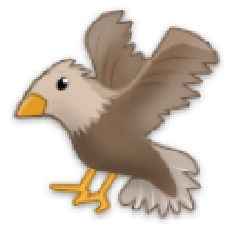

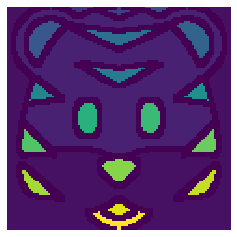

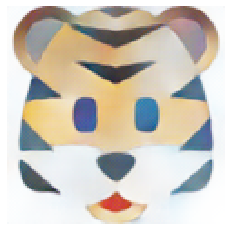

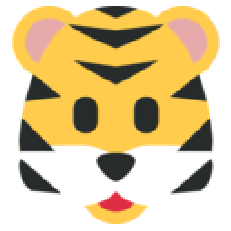

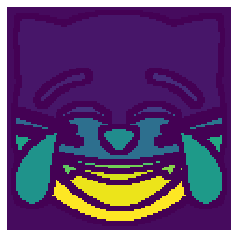

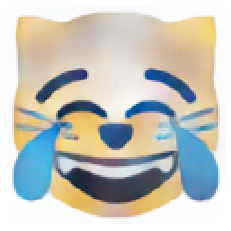

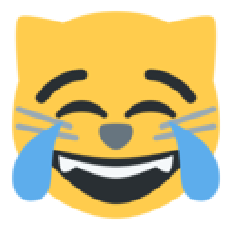

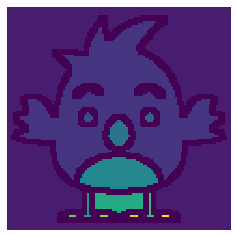

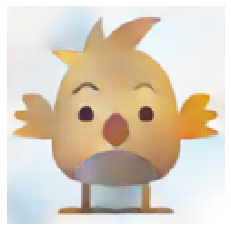

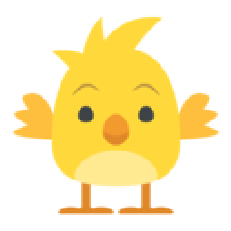

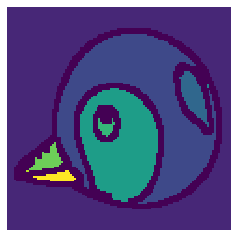

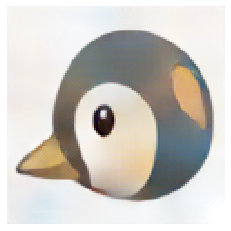

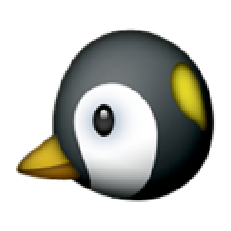

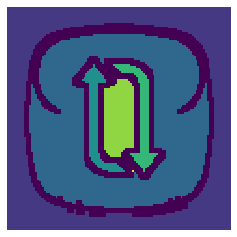

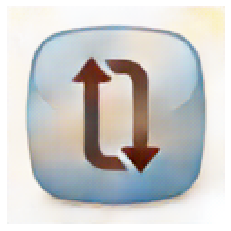

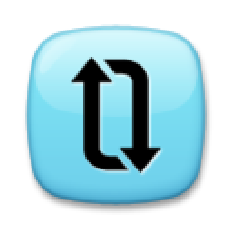

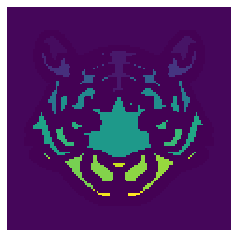

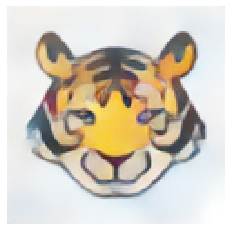

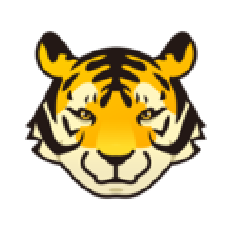

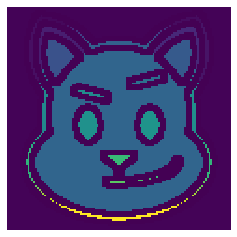

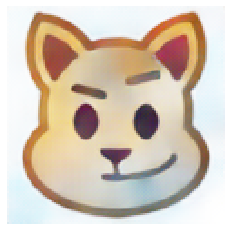

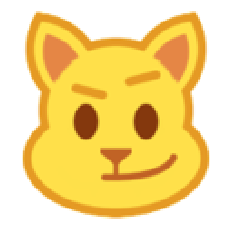

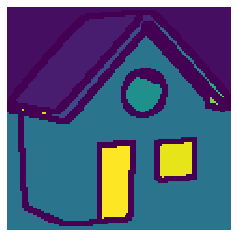

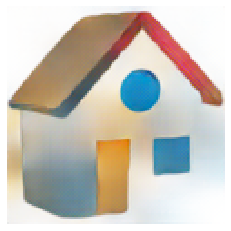

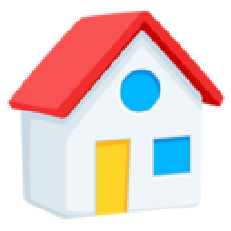

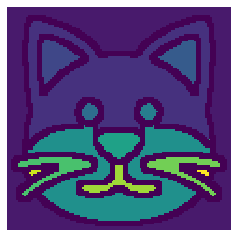

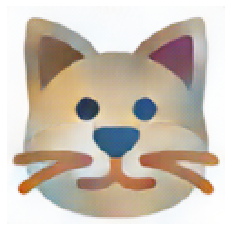

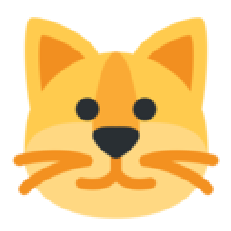

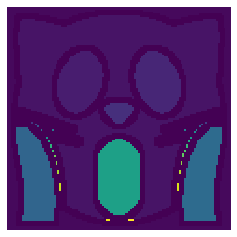

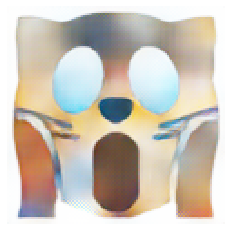

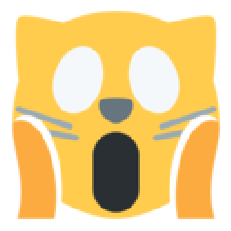

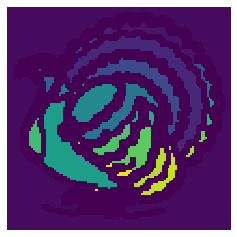

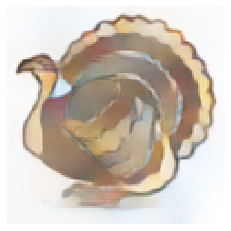

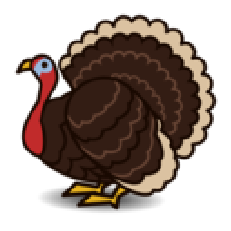

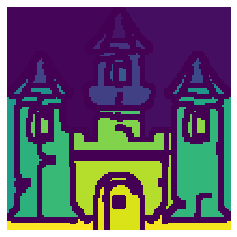

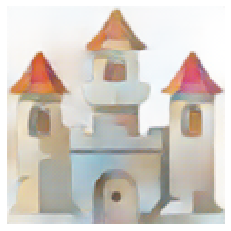

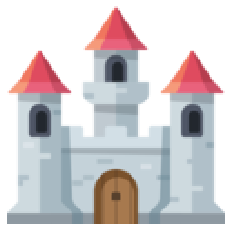


Test PSNR is 15.433971981944934


In [16]:
def test(model, test_loader, visualize=False, samples=1):
    model.train()
    test_loss = 0
    for edges, icons in tqdm(test_loader):
        if use_gpu:
            edges = edges.cuda()
        
        res = model(edges.float())
        res = res.detach().cpu().numpy()[0,:,:,:]
        icons = icons.float().numpy()[0, :, :, :]
        test_loss += psnr(res, icons)
        
        if visualize and samples > 0:
            samples -= 1
            res = res.transpose((1, 2, 0))
            res = res.clip(0, 1)
            icons = icons.transpose((1, 2, 0))
            edges = edges.detach().cpu().numpy()[0, 0, :, :]
            plt.matshow(edges)
            plt.axis('off')
            plt.show()
            plt.imshow(res)
            plt.axis('off')
            plt.show()
            plt.imshow(icons)
            plt.axis('off')
            plt.show()
            
    print(f"Test PSNR is {test_loss / len(test_loader)}")
test(net, test_loader, visualize=True, samples=15)